In [ ]:
import ntpath
import os
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow import keras

# Utility functions

In [ ]:
def convert_labels(labels):
    instruments = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
    for index, instrument in enumerate(instruments):
        labels = [index if label == instrument else label for label in labels]
    return labels

def reconvert_labels(labels):
    instruments = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
    return np.asarray([instruments[label] for label in labels])

def time_passed(t):
    now = time.time()
    print('Time passed: {} seconds.'.format(now - t))
    return now

# Read data

In [ ]:
t = time.time()

X_train = np.load('./dataset/X_train_data.npy', allow_pickle=True)
y_train = np.load('./dataset/y_train_data.npy', allow_pickle=True)
print(y_train.shape[0])
t = time_passed(t)
print(X_train.shape)

20115
Time passed: 7.749913215637207 seconds.
(20115, 128, 87)


In [ ]:
X_test = np.load('./dataset/X_test_data.npy', allow_pickle=True)
y_test = np.load('./dataset/y_test_data.npy', allow_pickle=True)
print(y_test.shape[0])
t = time_passed(t)
print(X_test.shape)

45661
Time passed: 17.201735734939575 seconds.
(45661, 128, 87)


In [ ]:
X_train = np.reshape(X_train, [-1, 128, 87, 1])
X_test = np.reshape(X_test, [-1, 128, 87, 1])
t = time_passed(t)

Time passed: 0.008810997009277344 seconds.


In [ ]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
print(X.shape)
y.shape

(65776, 128, 87, 1)


(65776, 11)

In [ ]:
randomize = np.arange(len(y))

np.random.shuffle(randomize)

X = X[randomize]
y = y[randomize]

In [ ]:
X_train = X[:30000]
y_train = y[:30000]
X_test = X[30000:]
y_test = y[30000:]

In [ ]:
y_train_classes = np.argmax(y_train, axis=-1)
y_train_classes = reconvert_labels(y_train_classes)
unique, counts = np.unique(y_train_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

[['cel' '1360']
 ['cla' '1141']
 ['flu' '1672']
 ['gac' '4445']
 ['gel' '6907']
 ['org' '1741']
 ['pia' '6750']
 ['sax' '942']
 ['tru' '880']
 ['vio' '1223']
 ['voi' '2939']]


In [ ]:
y_test_classes = np.argmax(y_test, axis=-1)
y_test_classes = reconvert_labels(y_test_classes)
unique, counts = np.unique(y_test_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

[['cel' '1648']
 ['cla' '1319']
 ['flu' '2023']
 ['gac' '5272']
 ['gel' '8183']
 ['org' '2212']
 ['pia' '8131']
 ['sax' '1063']
 ['tru' '1031']
 ['vio' '1406']
 ['voi' '3488']]


# CNN Network

In [ ]:
def create_model(input_shape, output_shape):
    model = keras.Sequential()
  
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(output_shape, activation='softmax'))

    return model

In [ ]:
model = create_model((128, 87, 1), 11)
model.summary()
t = time_passed(t)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 87, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 29, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 64)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 9, 64)         0

# Train model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_data=(X_test, y_test))
t = time_passed(t)

Epoch 1/200
938/938 [==============================] - 22s 12ms/step - loss: 2.4024 - accuracy: 0.2264 - val_loss: 2.2671 - val_accuracy: 0.2273
Epoch 2/200
938/938 [==============================] - 10s 10ms/step - loss: 2.0257 - accuracy: 0.3182 - val_loss: 2.1867 - val_accuracy: 0.3346
Epoch 3/200
938/938 [==============================] - 10s 10ms/step - loss: 1.9726 - accuracy: 0.3299 - val_loss: 2.1757 - val_accuracy: 0.3168
Epoch 4/200
938/938 [==============================] - 10s 10ms/step - loss: 1.9403 - accuracy: 0.3430 - val_loss: 2.1013 - val_accuracy: 0.3028
Epoch 5/200
938/938 [==============================] - 10s 10ms/step - loss: 1.9084 - accuracy: 0.3540 - val_loss: 2.0715 - val_accuracy: 0.2842
Epoch 6/200
938/938 [==============================] - 10s 11ms/step - loss: 1.8771 - accuracy: 0.3688 - val_loss: 2.0130 - val_accuracy: 0.3581
Epoch 7/200
938/938 [==============================] - 10s 10ms/step - loss: 1.8501 - accuracy: 0.3785 - val_loss: 1.9950 - val_ac

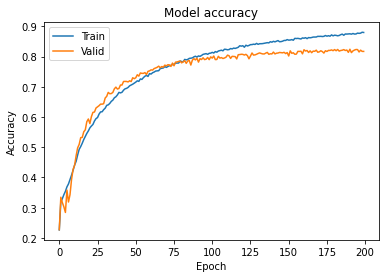

Time passed: 0.22568941116333008 seconds.


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('{}_accuracy.png'.format(time.strftime("%Y%m%d-%H%M%S")))
plt.show()

t = time_passed(t)


In [ ]:
model.save('./model')
print('Saved trained model')

t = time_passed(t)

INFO:tensorflow:Assets written to: /drive/My Drive/dataset/model/assets
Saved trained model
Time passed: 2.12528920173645 seconds.


In [ ]:
model = keras.models.load_model('./model')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
t = time_passed(t)

1118/1118 [==============================] - 4s 3ms/step - loss: 0.5821 - accuracy: 0.8169
Test loss: 0.5820885896682739
Test accuracy: 0.8168883919715881
Time passed: 6.066837787628174 seconds.


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=-1)
y_pred_classes = reconvert_labels(y_pred_classes)
y_pred_classes

array(['pia', 'pia', 'voi', ..., 'pia', 'sax', 'gel'], dtype='<U3')

In [ ]:
y_test_classes = np.argmax(y_test, axis=-1)
y_test_classes = reconvert_labels(y_test_classes)
y_test_classes

array(['pia', 'pia', 'voi', ..., 'gel', 'pia', 'org'], dtype='<U3')

In [ ]:
from sklearn.metrics import confusion_matrix
instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]
cf_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=instruments)

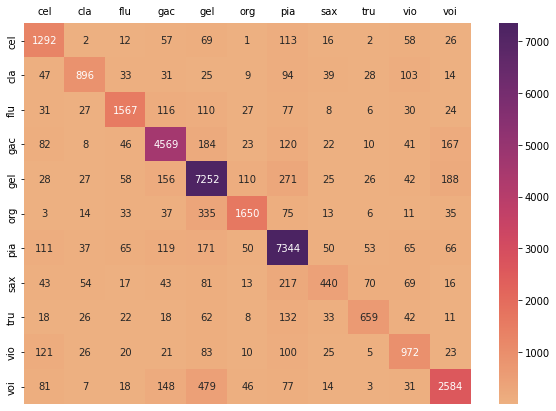

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.color_palette("flare", as_cmap=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=instruments, yticklabels=instruments, cmap="flare")